In [1]:
from utils import *
import tensorflow as tf
from sklearn.cross_validation import train_test_split
import time

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
trainset = sklearn.datasets.load_files(container_path = 'data', encoding = 'UTF-8')
trainset.data, trainset.target = separate_dataset(trainset,1.0)
print (trainset.target_names)
print (len(trainset.data))
print (len(trainset.target))

['negative', 'positive']
10662
10662


In [3]:
train_X, test_X, train_Y, test_Y = train_test_split(trainset.data, trainset.target, test_size = 0.2)

In [4]:
concat = ' '.join(trainset.data).split()
vocabulary_size = len(list(set(concat)))
data, count, dictionary, rev_dictionary = build_dataset(concat, vocabulary_size)
print('vocab from size: %d'%(vocabulary_size))
print('Most common words', count[4:10])
print('Sample data', data[:10], [rev_dictionary[i] for i in data[:10]])

vocab from size: 20332
Most common words [('film', 1453), ('movie', 1270), ('one', 727), ('like', 721), ('story', 477), ('much', 386)]
Sample data [542, 2601, 3458, 14052, 36, 8584, 219, 151, 19, 4040] ['rock', 'destined', '21st', 'centurys', 'new', 'conan', 'hes', 'going', 'make', 'splash']


In [5]:
GO = dictionary['GO']
PAD = dictionary['PAD']
EOS = dictionary['EOS']
UNK = dictionary['UNK']

In [6]:
size_layer = 128
num_layers = 2
embedded_size = 128
dimension_output = len(trainset.target_names)
learning_rate = 1e-3
maxlen = 50
batch_size = 128

In [7]:
def attention(inputs, attention_size):
    hidden_size = inputs.shape[2].value
    w_omega = tf.Variable(tf.random_normal([hidden_size, attention_size], stddev=0.1))
    b_omega = tf.Variable(tf.random_normal([attention_size], stddev=0.1))
    u_omega = tf.Variable(tf.random_normal([attention_size], stddev=0.1))
    with tf.name_scope('v'):
        v = tf.tanh(tf.tensordot(inputs, w_omega, axes=1) + b_omega)
    vu = tf.tensordot(v, u_omega, axes=1, name='vu')
    alphas = tf.nn.softmax(vu, name='alphas')
    output = inputs * tf.expand_dims(alphas, -1)
    return output, alphas, v

class Model:
    def __init__(self, size_layer, num_layers, embedded_size,
                 dict_size, dimension_output, learning_rate):
        
        def cells(reuse=False):
            return tf.nn.rnn_cell.LSTMCell(size_layer,initializer=tf.orthogonal_initializer(),reuse=reuse)
        
        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None])
        encoder_embeddings = tf.Variable(tf.random_uniform([dict_size, embedded_size], -1, 1))
        encoder_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.X)
        rnn_cells = tf.nn.rnn_cell.MultiRNNCell([cells() for _ in range(num_layers)])
        outputs, _ = tf.nn.dynamic_rnn(rnn_cells, encoder_embedded, dtype = tf.float32)
        self.attention_output, self.alphas, self.v = attention(outputs, maxlen)
        W = tf.get_variable('w',shape=(size_layer, dimension_output),initializer=tf.orthogonal_initializer())
        b = tf.get_variable('b',shape=(dimension_output),initializer=tf.zeros_initializer())
        self.logits = tf.matmul(self.attention_output[:,-1], W) + b
        self.cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = self.logits, labels = self.Y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        correct_pred = tf.equal(tf.argmax(self.logits, 1,output_type=tf.int32), self.Y)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(size_layer,num_layers,embedded_size,len(dictionary),dimension_output,learning_rate)
sess.run(tf.global_variables_initializer())

In [9]:
EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 5, 0, 0, 0
while True:
    lasttime = time.time()
    if CURRENT_CHECKPOINT == EARLY_STOPPING:
        print('break epoch:%d\n'%(EPOCH))
        break
        
    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    for i in range(0, (len(train_X) // batch_size) * batch_size, batch_size):
        batch_x = str_idx(train_X[i:i+batch_size],dictionary,maxlen)
        acc, loss, _ = sess.run([model.accuracy, model.cost, model.optimizer], 
                           feed_dict = {model.X : batch_x, model.Y : train_Y[i:i+batch_size]})
        train_loss += loss
        train_acc += acc
    
    for i in range(0, (len(test_X) // batch_size) * batch_size, batch_size):
        batch_x = str_idx(test_X[i:i+batch_size],dictionary,maxlen)
        acc, loss = sess.run([model.accuracy, model.cost], 
                           feed_dict = {model.X : batch_x, model.Y : test_Y[i:i+batch_size]})
        test_loss += loss
        test_acc += acc
    
    train_loss /= (len(train_X) // batch_size)
    train_acc /= (len(train_X) // batch_size)
    test_loss /= (len(test_X) // batch_size)
    test_acc /= (len(test_X) // batch_size)
    
    if test_acc > CURRENT_ACC:
        print('epoch: %d, pass acc: %f, current acc: %f'%(EPOCH,CURRENT_ACC, test_acc))
        CURRENT_ACC = test_acc
        CURRENT_CHECKPOINT = 0
    else:
        CURRENT_CHECKPOINT += 1
        
    print('time taken:', time.time()-lasttime)
    print('epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n'%(EPOCH,train_loss,
                                                                                          train_acc,test_loss,
                                                                                          test_acc))
    EPOCH += 1

epoch: 0, pass acc: 0.000000, current acc: 0.589355
time taken: 2.8746180534362793
epoch: 0, training loss: 0.691212, training acc: 0.514086, valid loss: 0.674135, valid acc: 0.589355

epoch: 1, pass acc: 0.589355, current acc: 0.675293
time taken: 2.7847111225128174
epoch: 1, training loss: 0.606451, training acc: 0.678504, valid loss: 0.617028, valid acc: 0.675293

epoch: 2, pass acc: 0.675293, current acc: 0.700684
time taken: 2.779869318008423
epoch: 2, training loss: 0.450668, training acc: 0.785393, valid loss: 0.645141, valid acc: 0.700684

epoch: 3, pass acc: 0.700684, current acc: 0.710938
time taken: 2.7860307693481445
epoch: 3, training loss: 0.307570, training acc: 0.859375, valid loss: 0.821693, valid acc: 0.710938

time taken: 2.7872474193573
epoch: 4, training loss: 0.201371, training acc: 0.909920, valid loss: 0.973106, valid acc: 0.710449

time taken: 2.774897813796997
epoch: 5, training loss: 0.140116, training acc: 0.935251, valid loss: 1.197291, valid acc: 0.702148


In [13]:
heatmap=sess.run(tf.nn.softmax(model.v),feed_dict={model.X:str_idx(test_X[1:2],dictionary,maxlen)})[0]

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

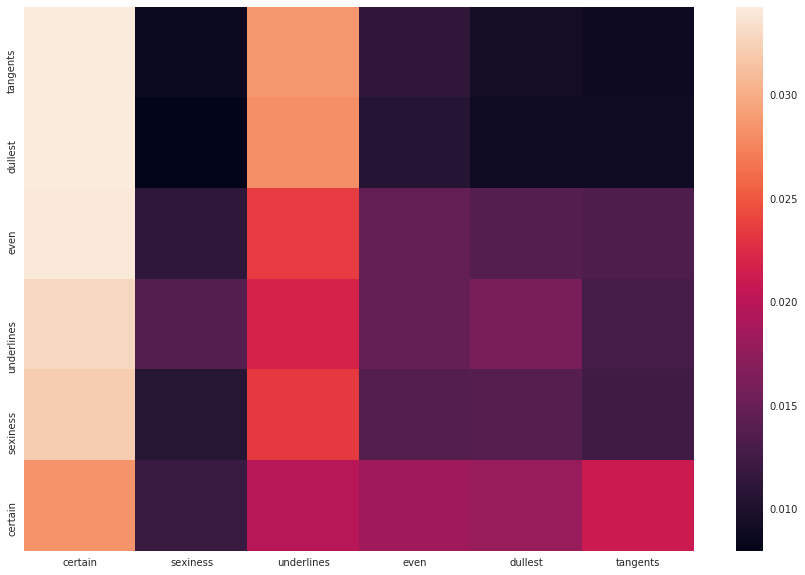

In [14]:
plt.figure(figsize=(15,10))
sns.heatmap(heatmap[-len(test_X[1].split()):,-len(test_X[1].split()):],
           xticklabels=test_X[1].split(),yticklabels=test_X[1].split()[::-1])
plt.show()